<a href="https://colab.research.google.com/github/kscaman/DL_ENS/blob/main/TP/deep_reinforcement_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning

In this practical, our objective is to replicate the famous [Deepmind paper on DQN](https://deepmind.google/discover/blog/deep-reinforcement-learning/) and train, using deep Q learning, an agent to play the Atari game [Breakout](https://www.gymlibrary.dev/environments/atari/breakout/)!
The code is adapted from the following [Github repo](https://github.com/jacobaustin123/pytorch-dqn/) and the [Pytorch tutorial on DQL](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html).


In [1]:
from IPython import display
from IPython.display import HTML
import gym
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from tqdm.notebook import tqdm

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

First load the environment using `env = gym.make('BreakoutDeterministic-v4')` (you can search the [gym documentation](https://www.gymlibrary.dev/environments/atari/breakout/)). The environment is initialized through `env.reset()`, updated via `env.step(action)`, and a random action can be created via `env.action_space.sample()`. Plot the state, action and reward after one random step.

Discrete(4)
Box(0, 255, (210, 160, 3), uint8)


c:\Users\Grégoire\AppData\Local\Programs\Python\Python310\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
c:\Users\Grégoire\AppData\Local\Programs\Python\Python310\lib\site-packages\gym\utils\passive_env_checker.py:289: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


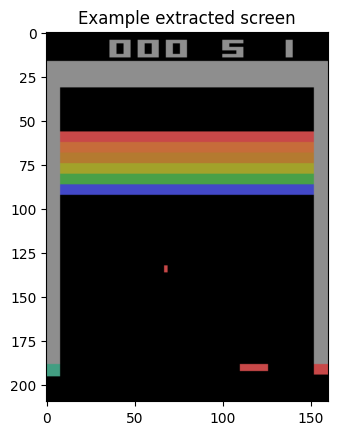

In [2]:
env = gym.make('BreakoutDeterministic-v4', render_mode='rgb_array')
env.reset()

# look at the action space
print(env.action_space)

# look at the observation space
print(env.observation_space)

_ = env.step(0)
_ = env.step(1)
_ = env.step(2)
_ = env.step(3)

# plot the current screen
plt.figure()
plt.imshow(env.render())
plt.title('Example extracted screen')
plt.show()

In what follows, we will encode a policy as a function `policy` that takes as input a state and returns a vector containing Q scores for each action (as a tensor of shape $(1,a)$ where $a$ is the number of possible actions). The following code will be used to create a video from a policy.

In [3]:
def create_video(policy, num_frames=100, preprocess=None):
    def animation_update(num):
        progress_bar.update(1)
        ax.clear()
        state = env.render()
        ax.imshow(state)
        state = state if preprocess is None else preprocess(state)
        action = policy(state)
        env.step(action)

    fig, ax = plt.subplots(figsize=(6, 4), dpi=100)
    env.reset()
    for _ in range(np.random.randint(1, 10)):
        env.step(0)
    
    state, _, done, _, _ = env.step(env.action_space.sample())
    progress_bar = tqdm(total=num_frames)
    anim = animation.FuncAnimation(fig, animation_update, frames=num_frames, interval=50)
    anim = HTML(anim.to_html5_video())
    progress_bar.close()
    plt.close()
    return anim

Create a video of a random agent playing Breakout.

In [4]:
# create a video of a random policy

anim = create_video(lambda x: env.action_space.sample(), num_frames=100)
display.display(anim)

  0%|          | 0/100 [00:00<?, ?it/s]

Create a class `EpsilonGreedy(policy, epsilon)` that takes a policy and returns its corresponding epsilon greedy strategy. To do so, create a method `__call__(self, state)` that returns a random action with probability epsilon, and the action chosen by the policy otherwise. Note that the output of the method should have a shape $(1,1)$.

Finally, create a video of an epsilon-greedy strategy that goes left expect with probability $\varepsilon = 0.5$.

In [5]:
class EpsilonGreedy:
    def __init__(self, policy, eps=0.1):
        self.policy = policy
        self.eps = eps
    
    def __call__(self, state):
        if np.random.rand() < self.eps:
            return np.random.randint(0, 4)
        else:
            return self.policy(state)

## State pre-processing
We would like to simplify the learning task by pre-processing the frames in two ways: 1) image pre-processing and 2) using frame sequences.

1) The atari frame is large and contains scores at the top of the screen that is not useful for our agent (as a reward is already available). Using `torchvision.transforms` methods (`ToPILImage`, `Grayscale`, `Resize`, `functional.crop`), crop the image to a $144\times 144$ image in grayscale, and flatten the resulting image to a vector of size $144\times 144$. Test this preprocessing on an Atari frame.

c:\Users\Grégoire\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\transforms\transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


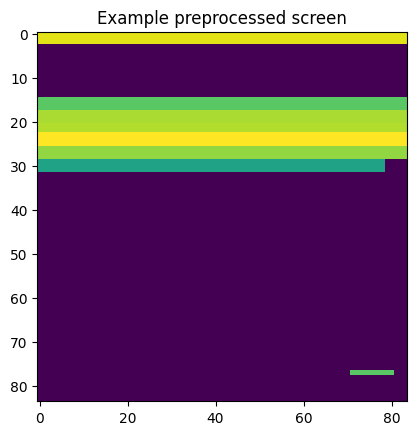

In [6]:
img_preprocess = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Grayscale(),
    lambda x : torchvision.transforms.functional.crop(x, 25, 8, 180, 144),
    torchvision.transforms.Resize((84, 84), 0),
    torchvision.transforms.ToTensor()
])

# try it on the current screen

state = env.render()
plt.figure()
plt.imshow(img_preprocess(state).squeeze().numpy())
plt.title('Example preprocessed screen')
plt.show()

To allow our model to access the speed and direction of the ball, augment the state of the environment by storing a sequence of 4 consecutive frames. To do so, create a class `FullPreprocessing` whose method `__call__(state)` updates a field `history` made of a concatenation of the 4 previous states and returns it.

In [7]:
### YOUR CODE HERE ###

## Deep Q Learning algorithm
We are now going to implement the DQN algorithm. First, we need to encode the policy using a neural network. Create a convolutional neural network that takes a sequence of 4 frames from the game and returns a score for each possible action. The CNN will consist of 3 convlution layers `nn.Conv2d(4, 32, 8, stride=4), nn.Conv2d(32, 64, 4, stride=2), nn.Conv2d(64, 64, 3, stride=1)` followed by an MLP with 2 linear layers `nn.Linear(7 * 7 * 64, 1024), nn.Linear(1024, 4)` and `F.leaky_relu` as activation functions.

In [8]:
### YOUR CODE HERE ###

To speed up the training, let's start from a pre-trained model and learn only the last layer. Create a function `good_init(model, filename)` that loads the model available [here](https://github.com/jacobaustin123/pytorch-dqn/blob/master/weights/breakout/good.pt), fix its parameters (`p.requires_grad=False` on all parameters p), and reinitialize the last layer.

In [9]:
### YOUR CODE HERE ###

We then define a replay memory to sample past (state, action, reward) tuples.

In [10]:
class Memory:
    def __init__(self, max_size):
        self.max_size = max_size
        self.full = False
        self.curr = 0

        self.states = torch.zeros((self.max_size, 84, 84), dtype=torch.uint8, device=device)
        self.rewards = torch.zeros((self.max_size, 1), device=device)
        self.actions = torch.zeros((self.max_size, 1), dtype=torch.uint8, device=device)
        self.terminals = torch.zeros((self.max_size, 1), dtype=torch.uint8, device=device)

    def store(self, state, action, reward, terminal):
        idx = self.curr % self.max_size

        self.states[idx] = (state * 255).to(torch.uint8).to(device)
        self.actions[idx] = action
        self.rewards[idx] = reward
        self.terminals[idx] = terminal

        self.increment()

    def size(self):
        return self.max_size if self.full else self.curr

    def increment(self):
        if self.curr + 1 == self.max_size:
            self.full = True

        self.curr = (self.curr + 1) % self.max_size

    def index(self, idx):
        if len(idx) == 0 or self.size() < idx.max():
            raise ValueError("Not enough elements in cache to sample {} elements".format(len(idx)))

        return (self.states[idx].to(device).to(torch.float32) / 255.), \
                self.actions[idx].to(device).to(torch.long), \
                self.rewards[idx].to(device), \
                self.terminals[idx].to(device).to(torch.int16)

    def _process_idx(self, idx):
        return idx % self.max_size

    def sample(self, N):
        if self.size() - 4 < N:
            raise ValueError("Not enough elements in cache to sample {} elements".format(N))

        idx = np.random.choice(self.size() - 4, N)
        idx = self._process_idx(idx)
        state_idx = self._process_idx((idx.reshape(-1, 1) + np.array([0, 1, 2, 3]).reshape(1, -1)).flatten())
        next_state_idx = self._process_idx((idx.reshape(-1, 1) + np.array([0, 1, 2, 3]).reshape(1, -1)).flatten() + 1)

        states = []
        next_states = []
        actions = []
        rewards = []
        terminals = []

        _, a, r, t = self.index(idx)
        s, _, _, _ = self.index(state_idx)
        ns, _, _, _ = self.index(next_state_idx)

        states.append(s)
        next_states.append(ns)
        actions.append(a)
        rewards.append(r)
        terminals.append(t)

        return torch.cat(states).reshape(-1, 4, states[0].shape[1], states[0].shape[2]), \
               torch.cat(next_states).reshape(-1, 4, states[0].shape[1], states[0].shape[2]), \
               torch.cat(actions), \
               torch.cat(rewards), \
               torch.cat(terminals)


The optimization step performs one step of Q-Learning. Fill in the blanks by computing the loss function, computing the correct gradient, clipping the gradient, and performing one step of the optimizer.

In [11]:
def optim_step(mem, model, target_model, loss_func, optimizer):
    states, next_states, actions, rewards, terminals = mem.sample(BATCH_SIZE)
    mask = (1 - terminals).float()
    y = rewards + mask * GAMMA * torch.max(target_model(next_states), dim=1).values.view(-1, 1).detach()
    y = y.squeeze()
    x = model(states)[range(BATCH_SIZE), actions.squeeze()]

    ### YOUR CODE HERE ###

This code initializes the training parameters, models and optimizers.

In [12]:
MEM_SIZE = int(1e5) # this is either 250k or 1 million in the paper (size of replay memory)
EPISODES = int(2e3) # total training episodes
BATCH_SIZE = 32 # minibatch update size
GAMMA = 0.99 # discount factor
UPDATE_FREQ = 4 # perform minibatch update once every UPDATE_FREQ
TARGET_UPDATE_EVERY = 40000 # (frames)
INIT_MEMORY_SIZE = 1000 #20000 # initial size of memory before minibatch updates begin
TEST_EVERY = 100 # (episodes)
NUM_TEST = 5

mem = Memory(MEM_SIZE)
model = Model().to(device)
good_init(model)
model = model.to(device)
target_model = Model().to(device)
target_model.load_state_dict(model.state_dict())
optimizer = optim.Adam(model.parameters(), lr=1e-5, eps=1.5e-4)
loss_func = nn.SmoothL1Loss()
num_frames = 0

NameError: name 'Model' is not defined

And finally the training loop! Fill in the gaps.

In [ ]:
def test():
    print("[TESTING]")
    total_reward = 0
    policy = EpsilonGreedy(model, 0.01)

    for i in range(NUM_TEST):
        ### YOUR CODE HERE ###

    total_reward /= NUM_TEST
    print(f"[TESTING] Total Reward: {total_reward:.1f}")

def train(episode, num_frames):
    epsilon = max(0.1, 1 - (0.9 * num_frames) / 2e4)
    policy = EpsilonGreedy(model, epsilon)
    ### YOUR CODE HERE ###

    while not done:
        ### YOUR CODE HERE ###

        if mem.size() < INIT_MEMORY_SIZE:
            continue

        if num_frames % UPDATE_FREQ == 0:
            optim_step(mem, model, target_model, loss_func, optimizer)

        if num_frames % TARGET_UPDATE_EVERY == 0: # reset target to source
            target_model.load_state_dict(model.state_dict())

    print(f"[EPISODE {episode}] Total Reward: {total_reward:.1f}, Epsilon: {epsilon:.2f}, Total Frames: {num_frames}, Memory Size: {mem.size()}")
    return num_frames

for episode in range(EPISODES):
    num_frames = train(episode, num_frames)
    if episode % TEST_EVERY == 0:
        test()

Create a video of the new agent playing Breakout. How is the agent performing?

In [ ]:
### YOUR CODE HERE ###